In [1]:
%matplotlib inline
%load_ext autoreload

In [2]:
import os
os.chdir('/home/jaentrouble/adipose_train3')
print(os.getcwd())

/home/jaentrouble/adipose_train3


In [3]:
import imageio as io
import json

img_names = os.listdir('data/done')
img = []
img_name_dict = {}
for idx, name in enumerate(img_names):
    img.append(io.imread('data/done/'+name))
    img_name_dict[name] = idx

json_names = os.listdir('data/save')
data = []
for name in json_names:
    with open('data/save/'+name,'r') as j:
        data.extend(json.load(j))
for datum in data :
    datum['image'] = img_name_dict[datum['image']]

In [4]:
data_train = data[:2600]
data_val = data[2600:2900]
data_test = data[2900:]

In [5]:
!git pull
%autoreload

Already up to date.


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from model_trainer import get_model
from box_models import *
from encoder_models import *
from functools import partial

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus :
    try :
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [7]:
img_size=(480,320)
encoder_f = hr_5_3_16_gap
box_f = dense_256_embed_128
savedfile_name = 'hr_5_3_16_d256_e128'
target_epoch = 200

In [8]:
test_model = get_model(encoder_f, box_f, img_size)


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 2070 SUPER, compute capability 7.5


In [9]:
from pathlib import Path
savedfile_name = Path(savedfile_name)
weight_path = 'savedmodels' / savedfile_name / str(target_epoch)
test_model.load_weights(str(weight_path))

In [10]:
from model_trainer import create_val_data

X_test, Y_test = create_val_data(img, data_test, img_size)

In [11]:
test_model.evaluate(X_test,Y_test, batch_size=10)

30/30 [==============================] - 6s 203ms/step - loss: 0.0057


0.005702457390725613

In [12]:
Target_X = {}
Target_X['image'] = X_test['image'][:10]
Target_X['pos'] = X_test['pos'][:10]
Target_Y = Y_test[:10]
Target_data = data_test[:10]
predict = test_model(Target_X)
predict = predict.numpy()

In [13]:
predict = np.clip(predict, 0, 1)
print(predict[5])

[0.6972656  0.24719238 0.9223633  0.56884766]


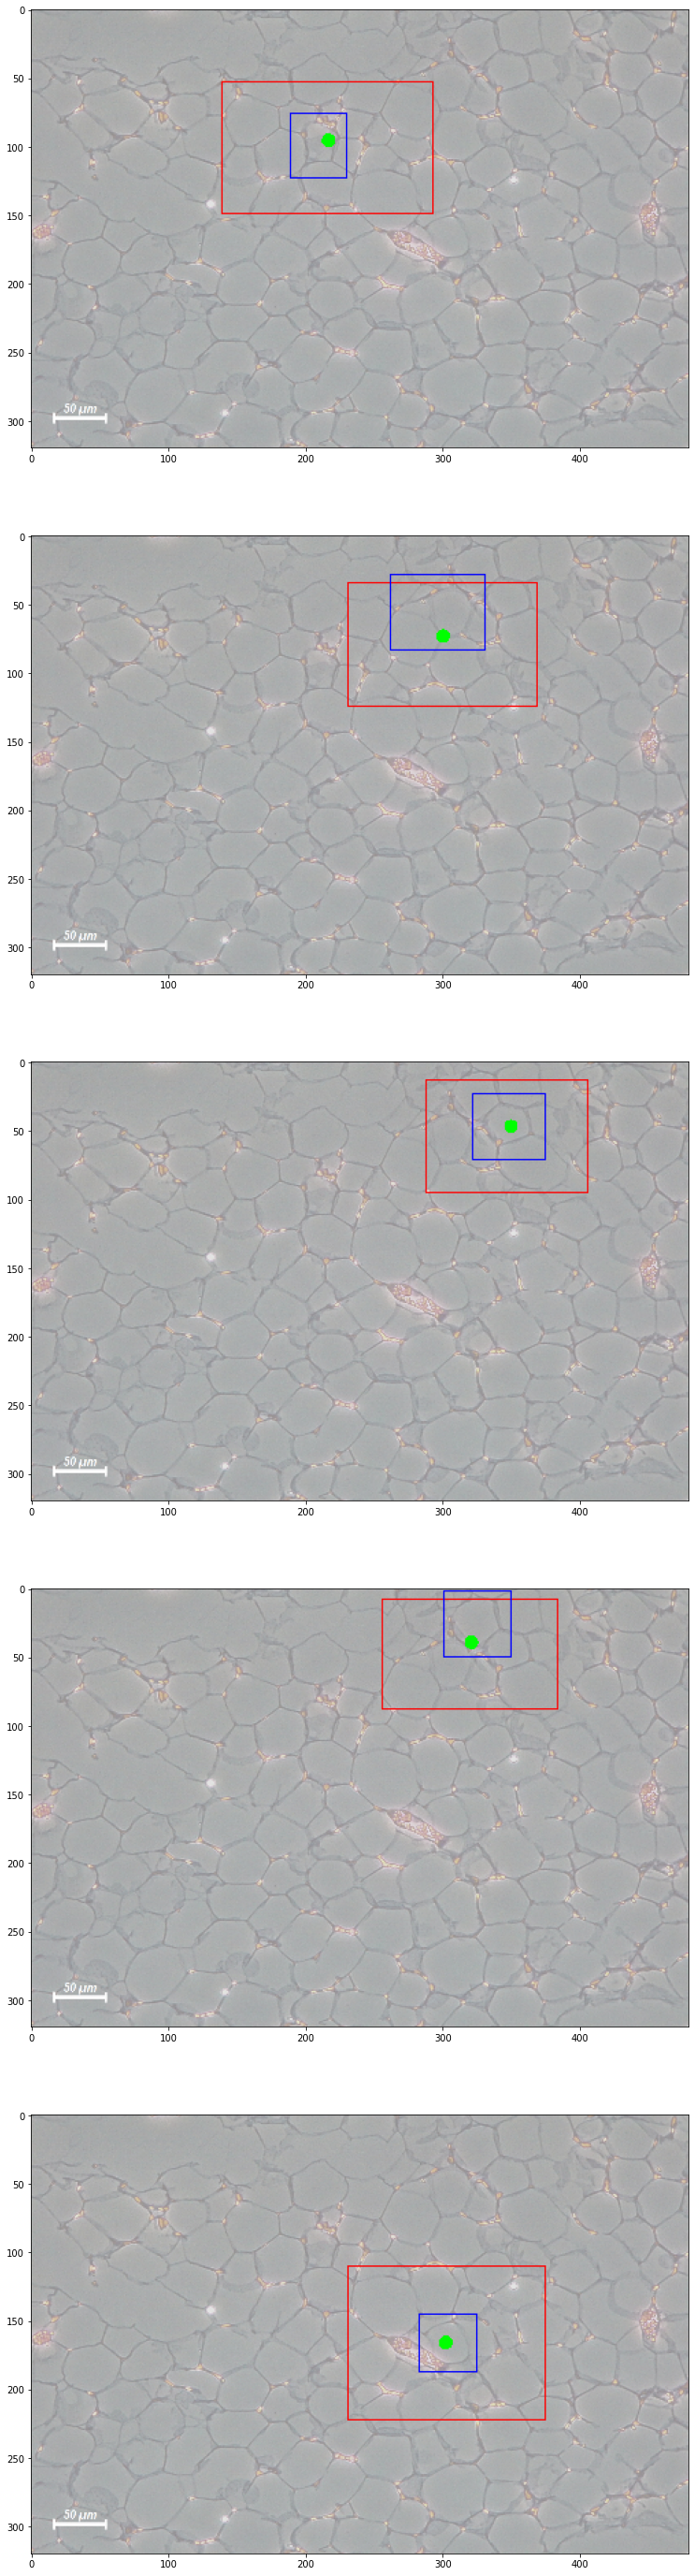

In [15]:
from skimage import draw
fig = plt.figure(figsize=(50,50))
for idx in range(5):
    ax = fig.add_subplot(5,1,idx+1)
    img = Target_X['image'][idx].copy().swapaxes(0,1)
    height, width = img.shape[:2]
    pos = Target_X['pos'][idx] * [width, height]
    xmin,ymin,xmax,ymax = predict[idx] * [width, height, width, height]
    rr, cc = draw.disk((pos[1],pos[0]),5, shape=img.shape[:2])
    img[rr,cc] = [0,255,0]
    rr, cc = draw.rectangle_perimeter((ymin,xmin),(ymax,xmax),shape=img.shape[:2])
    img[rr,cc] = [255,0,0]

    xmin,ymin,xmax,ymax = Target_Y[idx] * [width, height, width, height]
    rr, cc = draw.rectangle_perimeter((ymin,xmin),(ymax,xmax),shape=img.shape[:2])
    img[rr,cc] = [0,0,255]
    ax.imshow(img)
plt.show()